# Electricity modelling with a BAM

This example includes fitting a big data GAM (BAM) to UK electricity demand data, taken from the national grid. The dataset contains:

- **NetDemand** – net electricity demand
- **wM** – instantaneous temperature, averaged over several cities  
- **wM_s95** – exponential smooth of `wM`
- **Posan** – periodic index in $[0, 1]$ indicating the position along the year  
- **Dow** – factor variable indicating the day of the week 
- **Trend** – progressive counter, useful for defining the long-term trend  
- **Instant** - The hour $[0, 23]$ 
- **NetDemand.24** – 24 hour lagged version of `NetDemand`  
- **Year** - the year



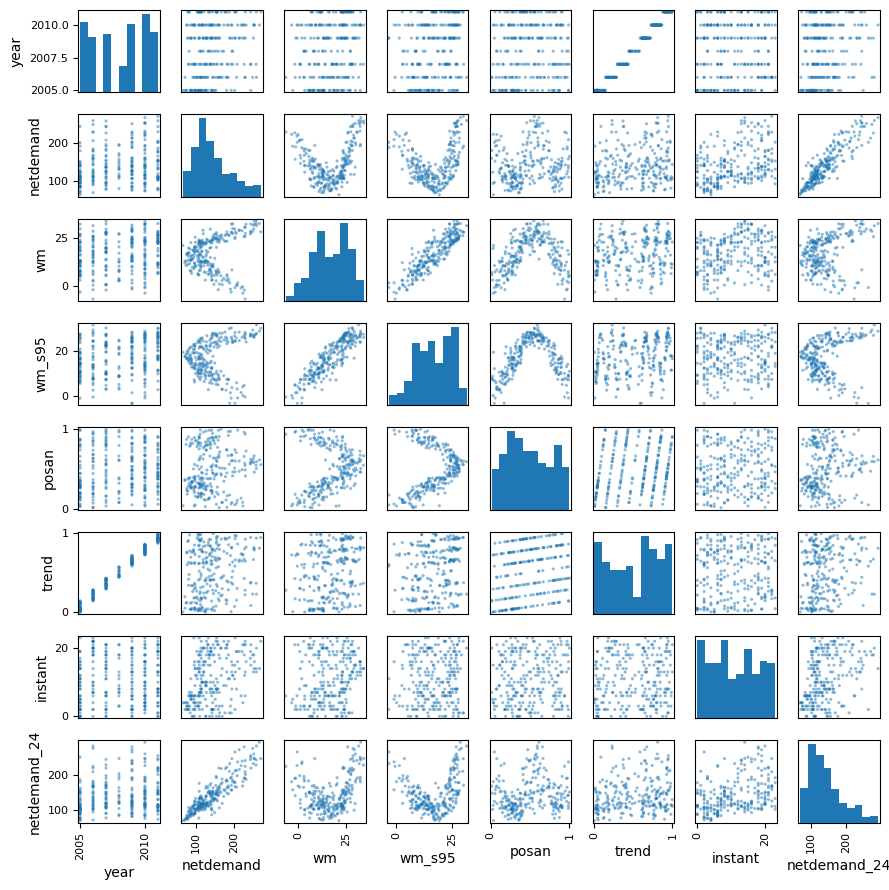

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

import pymgcv.plot as gplt
from pymgcv.terms import L, S, T
from pymgcv.utils import load_rdata_dataframe_from_url

data = load_rdata_dataframe_from_url(
    "https://github.com/mfasiolo/testGam/raw/master/data/gefcom_big.rda",
)
data.columns = [c.lower().replace(".", "_") for c in data.columns]
data["dow"] = data["dow"].astype("category")
pd.plotting.scatter_matrix(data.sample(n=250), s=20, figsize=(9,9))
plt.tight_layout()

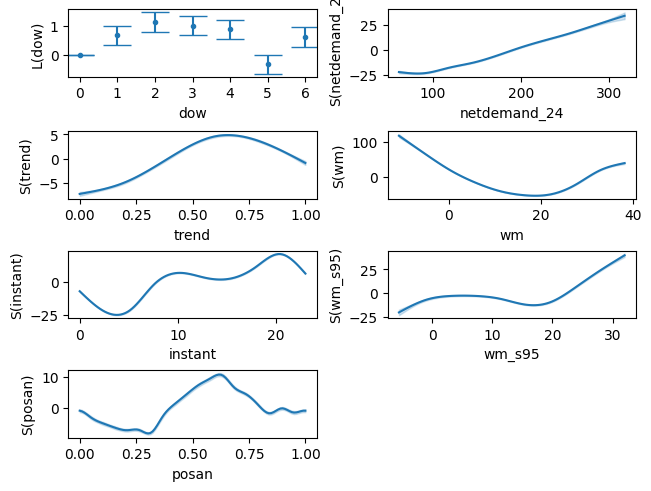

In [2]:
from pymgcv.basis_functions import CubicSpline
from pymgcv.gam import BAM

gam1 = BAM(
    {
    "netdemand":  (
        L("dow") +   # Encoded as category
        S("netdemand_24", bs=CubicSpline()) +
        S("trend", k=6, bs=CubicSpline()) +
        S("wm", bs=CubicSpline()) +
        S("instant", bs=CubicSpline()) +
        S("wm_s95", bs=CubicSpline()) +
        S("posan", bs=CubicSpline(cyclic=True), k=20)
    ), 
    }, 
 )


gam1.fit(data, discrete=True, n_threads=1) 
gplt.plot(gam1)
plt.show()

Check whether the bases are large enough

In [3]:
gam1.check_k()

,term,max_edf,edf,k_index,p_value
0,s(netdemand_24),9.0,8.371362,0.977012,0.0375
1,s(trend),5.0,4.938627,0.728228,0.0000
2,s(wm),9.0,8.961725,1.021851,0.9450
3,s(instant),9.0,8.989825,0.990962,0.2750
4,s(wm_s95),9.0,8.867216,1.015348,0.8500
5,s(posan),18.0,17.049568,0.830697,0.0000


The p-values for ``s(trend)`` and ``s(posan)`` are very low:

- Raising ``k`` for ``s(posan)`` may help.
- Raising ``k`` for ``s(trend)`` may help, but for time components like this, increasing `k` to much can lead to overfitting. It might be better to try improving the model in other ways (e.g. autoregressive components).
- The smooths of ``instant``, ``wm_s95`` and ``Instant`` have EDF values close to the maximum, so it might help to increase these too.

In [4]:
gam2 = BAM({
    "netdemand":  (
        L("dow") +   # Encoded as category
        S("netdemand_24", k=20, bs=CubicSpline()) +
        S("trend", k=6, bs=CubicSpline()) +
        S("wm", k=20, bs=CubicSpline()) +
        S("instant", k=20, bs=CubicSpline()) +
        S("wm_s95", k=20, bs=CubicSpline()) +
        S("posan", k=30, bs=CubicSpline(cyclic=True))
    ), 
    })
gam2.fit(data, discrete=True)
gam2.check_k()

,term,max_edf,edf,k_index,p_value
0,s(netdemand_24),19.0,11.775060,1.007657,0.6925
1,s(trend),5.0,4.939703,0.720882,0.0000
2,s(wm),19.0,17.350784,0.986407,0.1475
3,s(instant),19.0,18.420370,1.005573,0.6575
4,s(wm_s95),19.0,15.928629,0.991724,0.3175
5,s(posan),28.0,25.160270,0.847709,0.0000


- The EDF values are now all somewhat less than the maximum (except from trend, but this is OK).
- We can check if interaction terms might be useful, for example with ``instant`` (the temperature), by looking at the residuals.

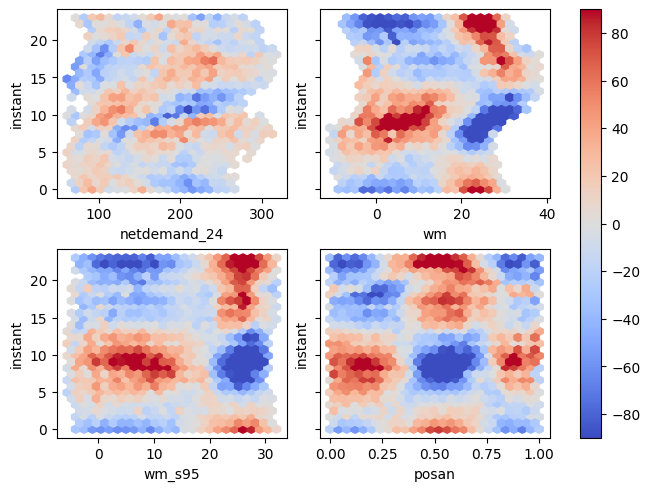

In [5]:
residuals = gam2.residuals()
plot_vars = ["netdemand_24", "wm", "wm_s95", "posan"]
fig, axes = plt.subplots(nrows=2, ncols=2, sharey=True, layout="constrained")

for var, ax in zip(plot_vars, axes.flatten(), strict=False):
    gplt.hexbin_residuals(
        residuals,
        var,
        "instant",
        data=data,
        ax=ax,
        )
fig.colorbar(axes[0,0].collections[0], ax=axes);

It's clear that we should include interaction terms! Because the variables are on different scales, we should use [`T`][pymgcv.terms.T]. We can include them as interaction only terms, and keep the original effects.

In [6]:
interaction_terms = (
    T("netdemand_24", "instant", k=(15, 15), interaction_only=True) +
    T("wm", "instant", k=(10, 10), interaction_only=True) +
    T("wm_s95", "instant", k=(15, 15), interaction_only=True) +
    T("posan", "instant", k=(10, 15), interaction_only=True)
)
# Take previous models predictors and extend the model
predictors = gam2.predictors.copy()
predictors["netdemand"].extend(interaction_terms)
gam3 = BAM(predictors)
gam3.fit(data, discrete=True)
gam3.check_k()

,term,max_edf,edf,k_index,p_value
0,s(netdemand_24),19.0,13.360622,0.971776,0.0250
1,s(trend),5.0,4.975395,0.650465,0.0000
2,s(wm),19.0,17.582837,1.011076,0.7675
3,s(instant),19.0,18.547421,1.035581,0.9950
4,s(wm_s95),19.0,17.492170,0.974010,0.0375
5,s(posan),28.0,26.707128,0.906030,0.0000
6,"ti(netdemand_24,instant)",196.0,103.933439,1.019063,0.9350
7,"ti(wm,instant)",81.0,54.844276,1.000472,0.4950
8,"ti(wm_s95,instant)",196.0,110.628848,1.007131,0.6500
9,"ti(posan,instant)",126.0,113.587174,0.937806,0.0000


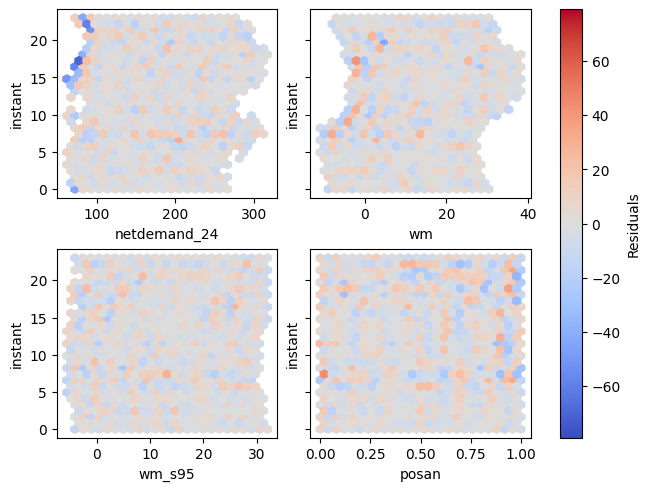

In [7]:
residuals = gam3.residuals()
fig, axes = plt.subplots(nrows=2, ncols=2, sharey=True, layout="constrained")

for var, ax in zip(plot_vars, axes.flatten(), strict=False):
    gplt.hexbin_residuals(residuals, var, "instant", data=data, ax=ax)

fig.colorbar(axes[0, 0].collections[0], ax=axes, orientation="vertical", label="Residuals");


Much better! If we check the AIC, it also suggests a better fit 

In [8]:
for name, m in {"Univariate smooths": gam2, "Interaction": gam3}.items():
    print(f"{name}: {m.aic()}")

Univariate smooths: 460416.5326344241
Interaction: 431496.1108823907


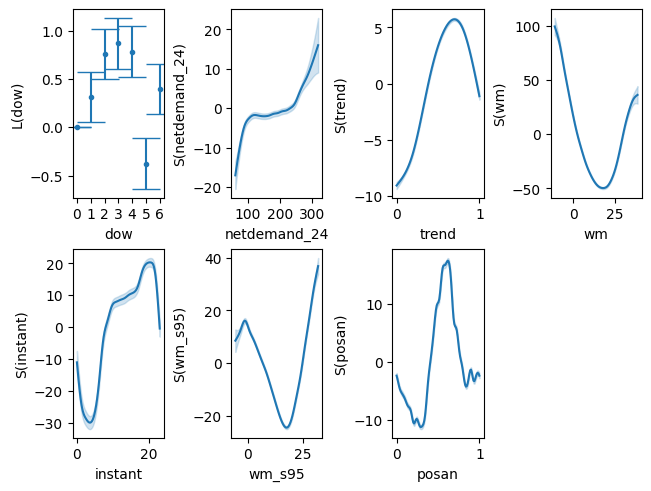

In [9]:
# The smooth and categorical term:
fig, axes = gplt.plot(gam3, to_plot=S | L, ncols=4)

 - We might be concerned with posan - it's quite wiggly! Maybe it's an issue with holidays.

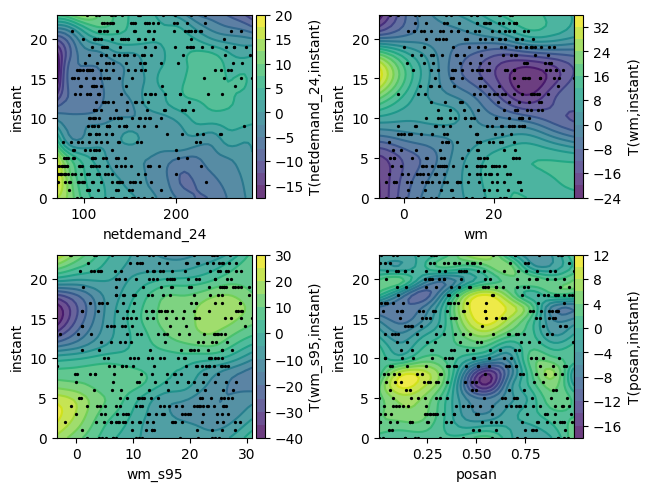

In [10]:
# The interaction terms - we'll just show a subset of the datapoints
fig, axes = gplt.plot(
    gam3,
    to_plot=T,
    scatter=True,
    data=data.sample(n=400),
    )